In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ..

/home/suriya/dcu/Group-Project


In [9]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from src.datapoint import read_non_sensor_data

![](features-gomez_et_al.png)

In [7]:
train_data_dir = 'data/tc4tl_training_data_v1/tc4tl/data/train/'
train_key = pd.read_csv('data/tc4tl_training_data_v1/tc4tl/docs/tc4tl_train_key.tsv', sep='\t')

In [45]:
def distance_from_rssi(rssi, TX, N):
    return np.power(10, (TX - rssi) / (10 * N))

distance_from_rssi(-51, -54, 2.1)

0.719685673001152

In [48]:
def cohort_2020_winning_sol_features(filepath, coarse_grained):
    filedump = open(filepath).read()
    ns = read_non_sensor_data(filedump)
    mean_rssi = np.array([ float(line.split(',')[-1])
                          for line in filedump.split('\n')
                          if 'Bluetooth' in line ]).mean()
    pla = float(ns['TXPower']) - 41 - mean_rssi
    pred_distance = distance_from_rssi(mean_rssi,
                                      TX=-52 if coarse_grained=='Y' else -54,
                                      N=2.6 if coarse_grained=='Y'  else 2.1)
    ns.update({
        'PathLossAttenuation' : pla,
        'MeanRssi' : mean_rssi,
        'CoarseGrained' : coarse_grained,
        'PredictedDistance' : pred_distance
    })
    return ns

In [49]:
filepath = os.path.join(train_data_dir, 'aajxgoxc_tc4tl20.csv')
cohort_2020_winning_sol_features(filepath, 'Y')

{'TXDevice': 'iPhone11',
 'TXPower': '8',
 'RXDevice': 'iPhone11',
 'TXCarry': 'pocket',
 'RXCarry': 'hand',
 'RXPose': 'standing',
 'TXPose': 'sitting',
 'PathLossAttenuation': 25.19147084421236,
 'MeanRssi': -58.19147084421236,
 'CoarseGrained': 'Y',
 'PredictedDistance': 1.7303481541669392}

In [50]:
features = []
for idx, row in tqdm(train_key.iterrows(), total=train_key.shape[0]):
    feat = cohort_2020_winning_sol_features(
        os.path.join(train_data_dir, row.fileid), row.coarse_grain)
    feat.update({
        'fileid' : row.fileid,
        'distance' : row.distance_in_meters
    })
    features.append(feat)

100%|██████████| 15552/15552 [00:15<00:00, 1027.42it/s]


In [59]:
trainframe = pd.DataFrame(features)
trainframe.to_csv('data/processed/2020_cohort_winning_sol.features.train.csv', index=False)
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,PredictedDistance,fileid,distance
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,2.453292,aaadbuvp_tc4tl20.csv,1.8
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,1.147594,aaamkcii_tc4tl20.csv,3.0
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,2.481524,aabqtowt_tc4tl20.csv,1.2
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,4.610273,aadkjwss_tc4tl20.csv,1.8
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,1.395231,aafzrgzt_tc4tl20.csv,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,2.682236,zzwcoemu_tc4tl20.csv,1.2
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,12.480233,zzwoqxuc_tc4tl20.csv,4.5
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,9.435060,zzymwbbb_tc4tl20.csv,1.2
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,2.977816,zzzflikz_tc4tl20.csv,1.8


### Predicted Distance Stats

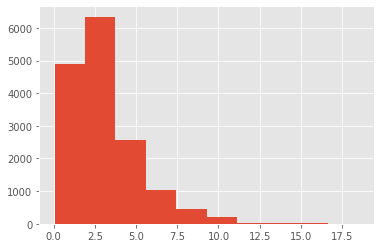

In [62]:
trainframe.PredictedDistance.hist();

In [63]:
trainframe.PredictedDistance.describe()

count    15552.000000
mean         3.132913
std          2.104072
min          0.050453
25%          1.674606
50%          2.614846
75%          3.926910
max         18.520465
Name: PredictedDistance, dtype: float64

## Min-Max Scaling

In [64]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

encoders = {
    'MeanRssi' : MinMaxScaler(),
    'PathLossAttenuation' : MinMaxScaler()
}

trainframe['NormMeanRssi'] = encoders['MeanRssi'].fit_transform(
                             trainframe['MeanRssi'].values.reshape(-1, 1)).reshape(-1)
trainframe['NormPathLossAttenuation'] = encoders['PathLossAttenuation'].fit_transform(
                                    trainframe['PathLossAttenuation'].values.reshape(-1, 1)).reshape(-1)

In [65]:
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,PredictedDistance,fileid,distance,NormMeanRssi,NormPathLossAttenuation
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,2.453292,aaadbuvp_tc4tl20.csv,1.8,0.343245,0.724865
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,1.147594,aaamkcii_tc4tl20.csv,3.0,0.470944,0.524600
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,2.481524,aabqtowt_tc4tl20.csv,1.2,0.340356,0.727730
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,4.610273,aadkjwss_tc4tl20.csv,1.8,0.235470,0.831733
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,1.395231,aafzrgzt_tc4tl20.csv,1.8,0.461564,0.607543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,2.682236,zzwcoemu_tc4tl20.csv,1.2,0.327185,0.740789
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,12.480233,zzwoqxuc_tc4tl20.csv,4.5,0.066840,0.906891
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,9.435060,zzymwbbb_tc4tl20.csv,1.2,0.114204,0.878336
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,2.977816,zzzflikz_tc4tl20.csv,1.8,0.302623,0.673093


## Label Encoding

In [66]:
catcols = ['TXDevice', 'RXDevice', 'TXCarry', 'RXCarry', 'RXPose', 'TXPose', 'CoarseGrained']
encoders.update({
    col : LabelEncoder() for col in catcols
})
for col in catcols:
    trainframe[col + 'Enc'] = encoders[col].fit_transform(trainframe[col].values.reshape(-1, 1)).reshape(-1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [67]:
trainframe.to_csv('data/processed/2020_cohort_winning_sol.enc.features.train.csv', index=False)
trainframe

,TXDevice,TXPower,RXDevice,TXCarry,RXCarry,RXPose,TXPose,PathLossAttenuation,MeanRssi,CoarseGrained,...,distance,NormMeanRssi,NormPathLossAttenuation,TXDeviceEnc,RXDeviceEnc,TXCarryEnc,RXCarryEnc,RXPoseEnc,TXPoseEnc,CoarseGrainedEnc
0,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.133482,-62.133482,Y,...,1.8,0.343245,0.724865,11,4,1,0,1,1,1
1,iPhone11,8,iPhoneXS,pocket,pocket,standing,standing,22.255556,-55.255556,N,...,3.0,0.470944,0.524600,0,8,1,1,1,1,0
2,iPhone6Plus,12,iPhone11,hand,hand,standing,standing,33.289089,-62.289089,N,...,1.2,0.340356,0.727730,5,0,0,0,1,1,0
3,iPhone7,12,iPhone11,pocket,pocket,sitting,sitting,38.938259,-67.938259,N,...,1.8,0.235470,0.831733,7,0,1,1,0,0,0
4,iPhone6s,12,iPhone8,hand,hand,standing,sitting,26.760797,-55.760797,Y,...,1.8,0.461564,0.607543,6,4,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,iPhoneX,12,iPhone8,pocket,hand,standing,standing,33.998435,-62.998435,N,...,1.2,0.327185,0.740789,11,4,1,0,1,1,0
15548,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,43.020677,-77.020677,N,...,4.5,0.066840,0.906891,2,2,0,0,0,1,0
15549,iPhoneXs_max,8,iPhoneXs_max,pocket,pocket,standing,sitting,41.469638,-74.469638,N,...,1.2,0.114204,0.878336,14,9,1,1,1,0,0
15550,iPhone11_Pro_max,7,iPhone7,hand,hand,sitting,standing,30.321346,-64.321346,Y,...,1.8,0.302623,0.673093,2,2,0,0,0,1,1


In [68]:
trainframe.columns

Index(['TXDevice', 'TXPower', 'RXDevice', 'TXCarry', 'RXCarry', 'RXPose',
       'TXPose', 'PathLossAttenuation', 'MeanRssi', 'CoarseGrained',
       'PredictedDistance', 'fileid', 'distance', 'NormMeanRssi',
       'NormPathLossAttenuation', 'TXDeviceEnc', 'RXDeviceEnc', 'TXCarryEnc',
       'RXCarryEnc', 'RXPoseEnc', 'TXPoseEnc', 'CoarseGrainedEnc'],
      dtype='object')

In [77]:
trainframe.distance = trainframe.distance.astype('str')

In [72]:
predictors = ['NormMeanRssi', 'NormPathLossAttenuation', 'PredictedDistance' ] + [ col + 'Enc' for col in catcols ]

## Evaluation

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [81]:
X_train, X_test, y_train, y_test = train_test_split(trainframe[predictors], trainframe.distance, test_size=0.3, random_state=69)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [83]:
ypred = rf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

         1.2       0.67      0.65      0.66       757
         1.8       0.71      0.71      0.71      1580
         3.0       0.50      0.53      0.51       758
         4.5       0.82      0.81      0.81      1571

    accuracy                           0.70      4666
   macro avg       0.67      0.67      0.67      4666
weighted avg       0.70      0.70      0.70      4666

